In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
from sklearn.linear_model import LinearRegression
import tensorflow as tf

2025-11-21 10:58:42.009269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and prepare dataframe

In [3]:
cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)
df.columns = cols
df['functional'] = ((df['functional']).astype(str).str.lower()=='yes').astype(int)
df = df[df['hour']==12]
df = df.drop('hour', axis=1)

In [4]:
# for label in df.columns[1:]:
#     plt.scatter(df[label], df['bike_count'])
#     plt.title(label)
#     plt.xlabel(label)
#     plt.ylabel('Bike count at noon')
#     plt.show()

In [5]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

Splitn the dataframe into training, validation and test sets

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/Users/jokello/Projects/DS/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Define X and y

In [7]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [8]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

Scale and sample the data

In [9]:
def scaler_func(dataframe,oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

Simple Linear Regression

In [10]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


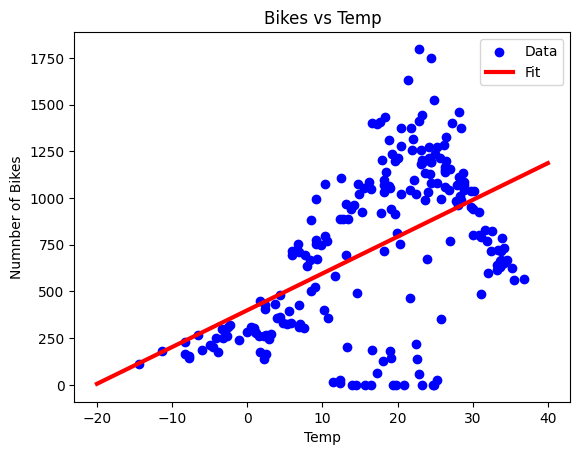

In [11]:
plt.scatter(X_train_temp, y_train_temp, color='blue', label='Data')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.title('Bikes vs Temp')
plt.xlabel('Temp')
plt.ylabel('Numnber of Bikes')
plt.legend()
plt.show()

Multiple Linear Regression

In [12]:
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [13]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
all_reg.score(X_test_all, y_test_all)

0.4671550176190039

Regression with Neural Networks

In [22]:
def plot_history(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/Users/jokello/Projects/DS/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [17]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [18]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1),
    y_train_temp,
    verbose = 0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

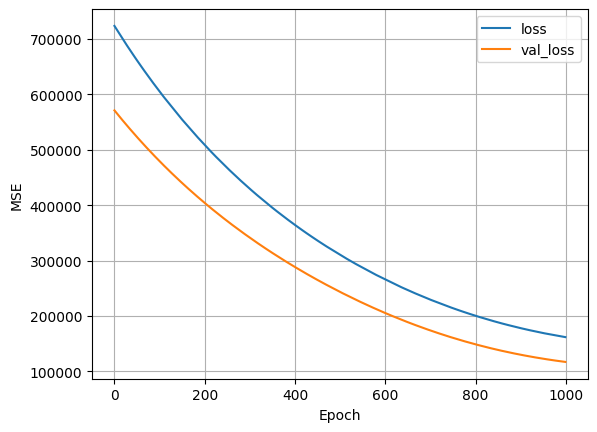

In [23]:
plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


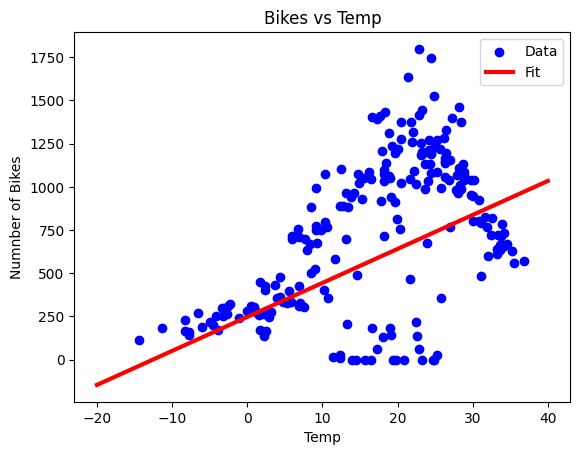

In [24]:
plt.scatter(X_train_temp, y_train_temp, color='blue', label='Data')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.title('Bikes vs Temp')
plt.xlabel('Temp')
plt.ylabel('Numnber of Bikes')
plt.legend()
plt.show()

Multiple Linear with NN

In [35]:
all_normalizer = tf.keras.layers.Normalization()
all_normalizer.adapt(X_train_all)

In [36]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

In [37]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [38]:
history = all_nn_model.fit(
    X_train_all,
    y_train_all,
    epochs = 1000,
    validation_data=(X_val_all, y_val_all),
    verbose=0
)

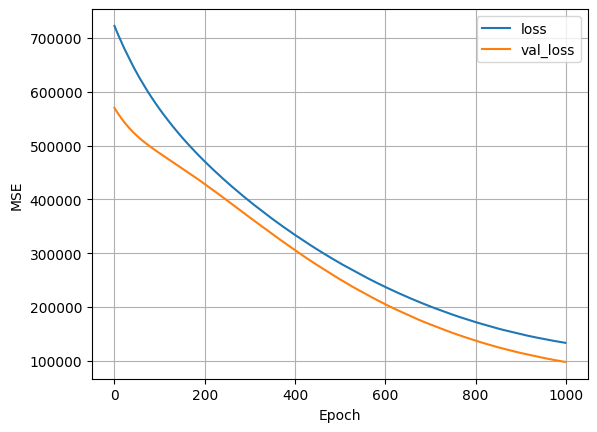

In [39]:
plot_history(history)

Neural Network

In [43]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [44]:
history = nn_model.fit(
    X_train_temp,
    y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    epochs=100,
    verbose=0
)

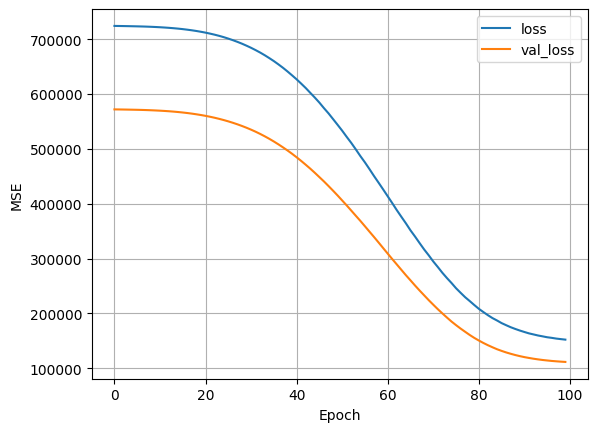

In [45]:
plot_history(history)

In [46]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [49]:
history = nn_model.fit(
    X_train_all,
    y_train_all,
    validation_data=(X_val_all, y_val_all),
    epochs=100,
    verbose=0
)

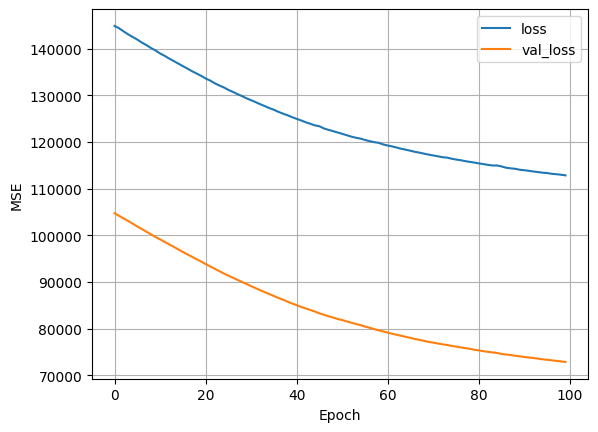

In [50]:
plot_history(history)